In [64]:
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC-ES2L",
    "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorCPM1",
    "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}

Common Models: {'ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-HR', 'MIROC6', 'CNRM-CM6-1', 'EC-Earth3', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'CESM2'}
No common dates for model UKESM1-0-LL


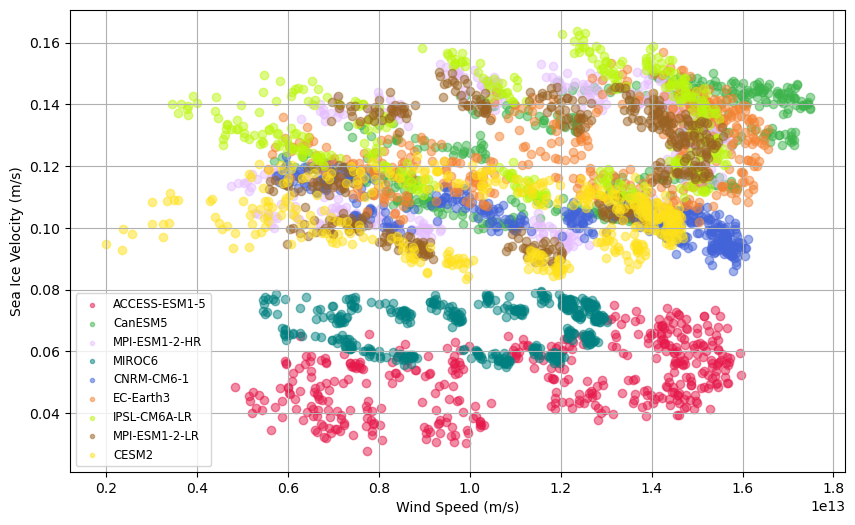

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

conc_folder = "siarea_data/"
sea_ice_folder = "sispeed_data/"

conc_files = sorted(glob.glob(os.path.join(conc_folder, "cmip6.historical.*.siarea.csv")))
sea_ice_files = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

conc_models = {os.path.basename(f).replace("cmip6.historical.", "").replace(".siarea.csv", ""): f 
               for f in conc_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f 
                  for f in sea_ice_files}

common_models = set(conc_models.keys()) & set(sea_ice_models.keys())
print("Common Models:", common_models)

monthly_ratio_dict = {}

plt.figure(figsize=(10, 6))

for model in common_models:
    try:
        conc_df = pd.read_csv(conc_models[model], index_col="time", parse_dates=True)
    except ValueError:
        conc_df = pd.read_csv(conc_models[model], index_col=0, parse_dates=True)
    try:
        ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    except ValueError:
        ice_df = pd.read_csv(sea_ice_models[model], index_col=0, parse_dates=True)

    common_time = conc_df.index.intersection(ice_df.index)
    if common_time.empty:
        print(f"No common dates for model {model}")
        continue
    conc_df = conc_df.loc[common_time]
    ice_df = ice_df.loc[common_time]

    wind_speed_avg = conc_df.mean(axis=1)  
    sea_ice_velocity_avg = ice_df.mean(axis=1)

    ratio = sea_ice_velocity_avg / wind_speed_avg.replace(0, pd.NA)

    ratio_df = pd.DataFrame({"ratio": ratio})
    ratio_df["month"] = ratio_df.index.month
    monthly_ratio = ratio_df.groupby("month")["ratio"].mean()
    monthly_ratio_dict[model] = monthly_ratio

    if sea_ice_velocity_avg.max() < 0.01:
        print(f"Low sea ice velocity in model: {model}")

    color = model_colors.get(model, "#000000") 
    plt.scatter(wind_speed_avg, sea_ice_velocity_avg, color=color, alpha=0.5, label=model)

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Sea Ice Velocity (m/s)")
# plt.title("Wind Speed vs Sea Ice Velocity Across CMIP6 Models")
plt.legend(loc="best", fontsize="small", markerscale=0.5)
plt.grid(True)
plt.show()


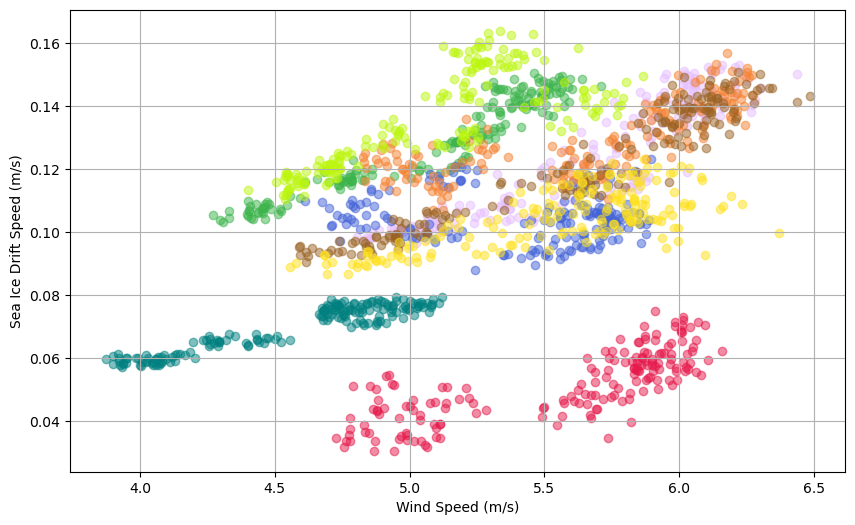

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

wind_folder = "wind_speed_data/"
sea_ice_folder = "sispeed_data/"

wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))
sea_ice_files = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

wind_models = {os.path.basename(f).replace("_wind_speed.csv", ""): f for f in wind_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f for f in sea_ice_files}

# print("Wind Models:", list(wind_models.keys()))
# print("Sea Ice Models:", list(sea_ice_models.keys()))

common_models = set(wind_models.keys()) & set(sea_ice_models.keys())
# print("Common Models:", common_models)

monthly_ratio_dict = {}

plt.figure(figsize=(10, 6))

for model in common_models:
    wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)

    common_time = wind_df.index.intersection(ice_df.index)
    wind_df = wind_df.loc[common_time]
    ice_df = ice_df.loc[common_time]
   
    wind_speed_avg = wind_df.mean(axis=1)
    sea_ice_velocity_avg = ice_df.mean(axis=1)

    ratio = sea_ice_velocity_avg / wind_speed_avg.replace(0, pd.NA)

    ratio_df = pd.DataFrame({"ratio": ratio})
    ratio_df["month"] = ratio_df.index.month
    monthly_ratio = ratio_df.groupby("month")["ratio"].mean()
    monthly_ratio_dict[model] = monthly_ratio
    
    if sea_ice_velocity_avg.max() < 0.01:
        print(f"Low sea ice velocity in model: {model}")

    color = model_colors.get(model, "#000000")
    plt.scatter(wind_speed_avg, sea_ice_velocity_avg, color=color, alpha=0.5, label=model)

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Sea Ice Drift Speed (m/s)")
# plt.title("Wind Speed vs Sea Ice Velocity Across CMIP6 Models")
# plt.legend(loc="best", fontsize="small", markerscale=0.5)
plt.grid(True)
plt.show()

In [56]:
import os
import glob

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 1) ERA5 10 m wind (m/s)
era5_file = "/Users/akikomotoki/Documents/Research/sea_ice_variability/Research/71a2be00d7b74ef6244cb3220978c974.grib"
ds_wind   = xr.open_dataset(era5_file, engine="cfgrib")
wind10    = ds_wind["si10"]                              # confirm variable name
wind_mon  = wind10.resample(time="1M").mean()
obs_wind  = wind_mon.mean(dim=["latitude", "longitude"])  # monthly spatial mean

# 2) NSIDC sea‑ice drift speed (m/s)
drift_file = "/Users/akikomotoki/Desktop/thesis/observational data/nsidc_ice_motion_monthly_1978-2023.nc"
ds_drift   = xr.open_dataset(drift_file)
# if drift_speed is in cm/s, convert to m/s; otherwise skip the division
drift_spd  = ds_drift["drift_speed"] / 100  
drift_mon  = drift_spd.resample(time="1M").mean()
obs_drift  = drift_mon.mean(dim=["y", "x"])              # monthly spatial mean

# compute overall time‐means
obs_x = float(obs_wind.mean())   # mean wind speed
obs_y = float(obs_drift.mean())  # mean drift speed

print(f"Observational mean wind: {obs_x:.3f} m/s, mean drift: {obs_y:.3f} m/s")


/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


Observational mean wind: 5.440 m/s, mean drift: 0.063 m/s


/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1368277093.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1368277093.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(ice_models[model], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1368277093.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1368277093.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(ice_models[model], index_col="time", parse_dates=True

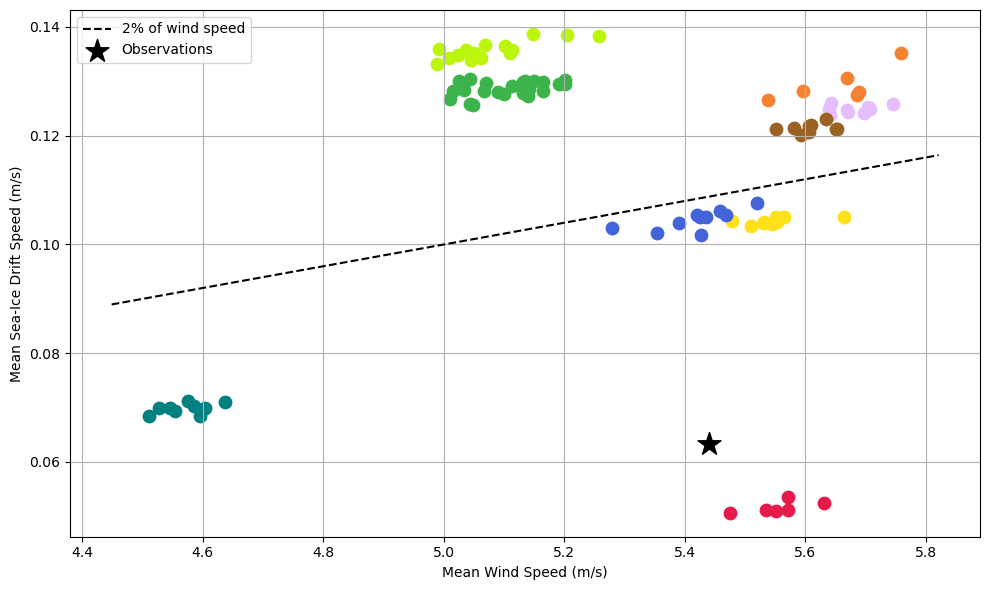

In [59]:
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

wind_folder    = "wind_speed_data/"
sea_ice_folder = "sispeed_data/"

wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))
ice_files  = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

wind_models = {os.path.basename(f).replace("_wind_speed.csv",""): f for f in wind_files}
ice_models  = {os.path.basename(f).replace("_sispeed.area_mean.csv",""): f for f in ice_files}

common_models = set(wind_models) & set(ice_models)

plt.figure(figsize=(10, 6))

for model in sorted(common_models):
    wdf = (
        pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
          .resample("M").mean()
    )
    idf = (
        pd.read_csv(ice_models[model], index_col="time", parse_dates=True)
          .resample("M").mean()
    )
    idx = wdf.index.intersection(idf.index)
    wdf = wdf.loc[idx]
    idf = idf.loc[idx]
    
    ens_list = wdf.columns.intersection(idf.columns)
    color = model_colors.get(model, "#000000")
    
    # one point per ensemble: time‐mean wind vs time‐mean drift
    for ens in ens_list:
        x = wdf[ens].mean(skipna=True)
        y = idf[ens].mean(skipna=True)
        plt.scatter(x, y,
                    color=color,
                    s=80,
                    )

# 2% reference line
ax = plt.gca()
x_min, x_max = ax.get_xlim()
xs = np.linspace(x_min, x_max, 100)

ax.plot(xs, 0.02*xs, 'k--', linewidth=1.5, label='2% of wind speed')

x_text = xs[-1]
y_text = 0.02 * x_text

ax.scatter(obs_x, obs_y,
           color='k', marker='*', s=300,
           label="Observations")


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          fontsize="medium", loc="best")

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(),
#            title="Model", fontsize="small", markerscale=1.2, loc="best")

plt.xlabel("Mean Wind Speed (m/s)")
plt.ylabel("Mean Sea‑Ice Drift Speed (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1306689452.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_df = wind_df.resample('M').mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1306689452.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ice_df = ice_df.resample('M').mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1306689452.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_df = wind_df.resample('M').mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1306689452.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ice_df = ice_df.resample('M').mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1306689452.py:21: FutureWarning: 'M' is deprecated a

Overall overlapping period: 2000-01-31 00:00:00 to 2014-12-31 00:00:00
Common time axis sample: DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31'],
              dtype='datetime64[ns]', freq='ME')  ... Total: 180
Model ACCESS-ESM1-5: Plotting 180 points
Model CanESM5: Plotting 180 points
Model MPI-ESM1-2-HR: Plotting 180 points
Model MIROC6: Plotting 180 points
Model CNRM-CM6-1: Plotting 180 points
Model EC-Earth3: Plotting 180 points
Model IPSL-CM6A-LR: Plotting 180 points
Model MPI-ESM1-2-LR: Plotting 180 points
Model CESM2: Plotting 180 points


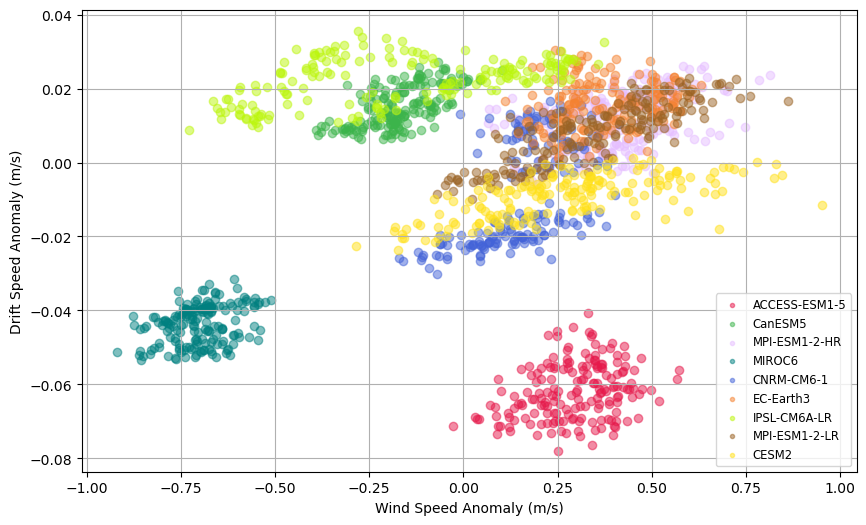

In [5]:
wind_folder = "wind_speed_data/"
sea_ice_folder = "sispeed_data/"

wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))
sea_ice_files = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

wind_models = {os.path.basename(f).replace("_wind_speed.csv", ""): f for f in wind_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f for f in sea_ice_files}

common_models = set(wind_models.keys()) & set(sea_ice_models.keys())

wind_avg_dict = {}
sea_ice_avg_dict = {}
wind_weight = {}
sea_ice_weight = {}

for model in common_models:
    wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
 
    wind_df = wind_df.resample('M').mean()
    ice_df = ice_df.resample('M').mean()
    
    # compute ensemble mean for each month
    wind_avg = wind_df.mean(axis=1)
    ice_avg = ice_df.mean(axis=1)
    
    wind_avg_dict[model] = wind_avg
    sea_ice_avg_dict[model] = ice_avg
    
    # number of ensemble members (columns) for weighting.
    wind_weight[model] = wind_df.shape[1]
    sea_ice_weight[model] = ice_df.shape[1]

def get_overlap(series_dict):
    min_dates = [s.index.min() for s in series_dict.values()]
    max_dates = [s.index.max() for s in series_dict.values()]
    return max(min_dates), min(max_dates)

common_start_wind, common_end_wind = get_overlap(wind_avg_dict)
common_start_ice, common_end_ice = get_overlap(sea_ice_avg_dict)

common_start = max(common_start_wind, common_start_ice)
common_end = min(common_end_wind, common_end_ice)
print("Overall overlapping period:", common_start, "to", common_end)

common_time = pd.date_range(start=common_start, end=common_end, freq='M')
print("Common time axis sample:", common_time[:5], " ... Total:", len(common_time))

for model in common_models:
    wind_avg_dict[model] = wind_avg_dict[model].reindex(common_time, method='nearest', tolerance=pd.Timedelta('2D'))
    sea_ice_avg_dict[model] = sea_ice_avg_dict[model].reindex(common_time, method='nearest', tolerance=pd.Timedelta('2D'))

# multi-model weighted mean for wind and sea ice anomalies
wind_all = pd.Series(index=common_time, dtype=float)
total_wind_weight = sum(wind_weight.values())
sea_ice_all = pd.Series(index=common_time, dtype=float)
total_sea_ice_weight = sum(sea_ice_weight.values())

for t in common_time:
    weighted_wind_sum = sum(wind_weight[model] * wind_avg_dict[model].loc[t] 
                            for model in common_models if pd.notna(wind_avg_dict[model].loc[t]))
    wind_all.loc[t] = weighted_wind_sum / total_wind_weight
    
    weighted_ice_sum = sum(sea_ice_weight[model] * sea_ice_avg_dict[model].loc[t] 
                           for model in common_models if pd.notna(sea_ice_avg_dict[model].loc[t]))
    sea_ice_all.loc[t] = weighted_ice_sum / total_sea_ice_weight

plt.figure(figsize=(10, 6))
for model in common_models:
    wind_anomaly = (wind_avg_dict[model] - wind_all).dropna()
    ice_anomaly = (sea_ice_avg_dict[model] - sea_ice_all).dropna()

    print(f"Model {model}: Plotting {len(wind_anomaly)} points")

    color = model_colors.get(model, "#000000")
    plt.scatter(wind_anomaly, ice_anomaly, color=color, alpha=0.5, label=model)

plt.xlabel("Wind Speed Anomaly (m/s)")
plt.ylabel("Drift Speed Anomaly (m/s)")
# plt.title("Anomalies of Wind Speed vs Sea Ice Velocity Across CMIP6 Models")
plt.legend(loc="best", fontsize="small", markerscale=0.5)
plt.grid(True)
plt.show()


/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/2171922213.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wdf = (pd.read_csv(wind_models[m], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/2171922213.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idf = (pd.read_csv(ice_models[m],  index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/2171922213.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wdf = (pd.read_csv(wind_models[m], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/2171922213.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idf = (pd.read_csv(ice_models[m],  index_col="time", pa

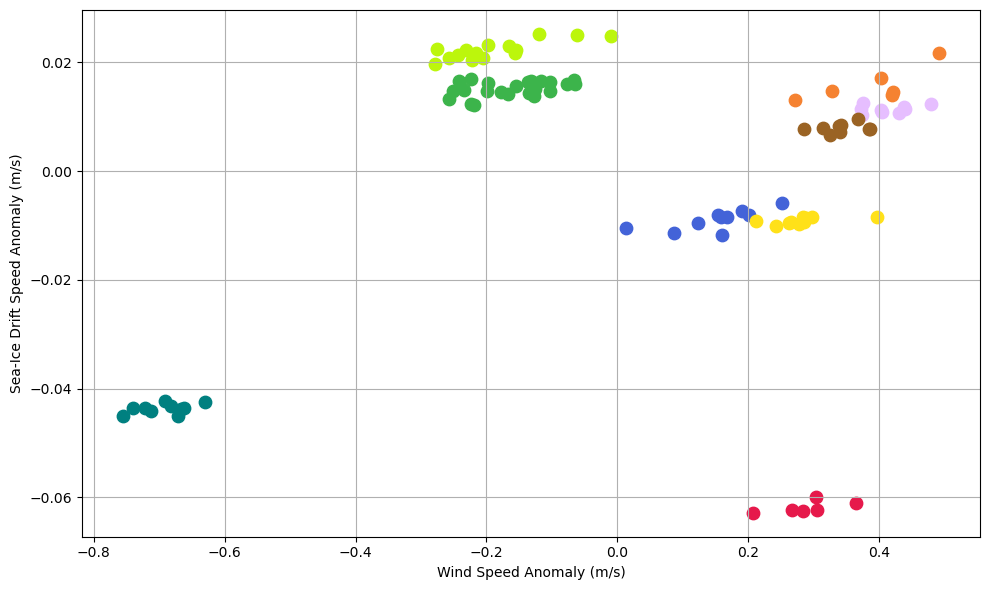

In [31]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

wind_folder    = "wind_speed_data/"
sea_ice_folder = "sispeed_data/"

wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))
ice_files  = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

wind_models = {os.path.basename(f).replace("_wind_speed.csv",""): f for f in wind_files}
ice_models  = {os.path.basename(f).replace("_sispeed.area_mean.csv",""): f for f in ice_files}

common_models = set(wind_models) & set(ice_models)

wind_df_dict = {}
ice_df_dict  = {}
wind_weight  = {}
ice_weight   = {}

for m in common_models:
    wdf = (pd.read_csv(wind_models[m], index_col="time", parse_dates=True)
             .resample("M").mean())
    idf = (pd.read_csv(ice_models[m],  index_col="time", parse_dates=True)
             .resample("M").mean())

    idx = wdf.index.intersection(idf.index)
    wdf = wdf.loc[idx]
    idf = idf.loc[idx]

    wind_df_dict[m] = wdf
    ice_df_dict[m]  = idf
    wind_weight[m]  = wdf.shape[1]  # number of ensemble members
    ice_weight[m]   = idf.shape[1]

all_idx = pd.Index([])
for df in wind_df_dict.values():
    all_idx = all_idx.union(df.index)
common_time = pd.date_range(
    start = max(df.index.min() for df in wind_df_dict.values()),
    end   = min(df.index.max() for df in wind_df_dict.values()),
    freq  = "M"
)

total_wt_w = sum(wind_weight.values())
total_wt_i = sum(ice_weight.values())

wind_all    = pd.Series(index=common_time, dtype=float)
sea_ice_all = pd.Series(index=common_time, dtype=float)

for t in common_time:
        w_sum = sum(
        wind_weight[m] * wind_df_dict[m].loc[t].mean(skipna=True)
        for m in common_models
        if t in wind_df_dict[m].index
    )
    i_sum = sum(
        ice_weight[m] * ice_df_dict[m].loc[t].mean(skipna=True)
        for m in common_models
        if t in ice_df_dict[m].index
    )
    wind_all.loc[t]    = w_sum / total_wt_w
    sea_ice_all.loc[t] = i_sum / total_wt_i

# 5) Scatter one point per ensemble member: time‐mean of its anomaly
plt.figure(figsize=(10, 6))

for m in common_models:
    wdf = wind_df_dict[m]
    idf = ice_df_dict[m]
    color = model_colors.get(m, "#000000") 

    ens_list = wdf.columns.intersection(idf.columns)
    for ens in ens_list:
        # anomaly time series
        wanom = wdf[ens].reindex(common_time) - wind_all
        ianom = idf[ens].reindex(common_time)  - sea_ice_all
        # time‐mean anomaly → one scalar per ensemble member
        x = wanom.mean(skipna=True)
        y = ianom.mean(skipna=True)
        plt.scatter(
            x, y,
            color=color,
            s=80,
            label=m  
        )

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(
#     by_label.values(),
#     by_label.keys(),
#     title="Model",
#     fontsize="small",
#     markerscale=1.2,
#     loc="best"
# )

plt.xlabel("Wind Speed Anomaly (m/s)")
plt.ylabel("Sea‑Ice Drift Speed Anomaly (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1100704485.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1100704485.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1100704485.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_2269/1100704485.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.read_csv(sea_ice_models[model], index_col="time", parse_da

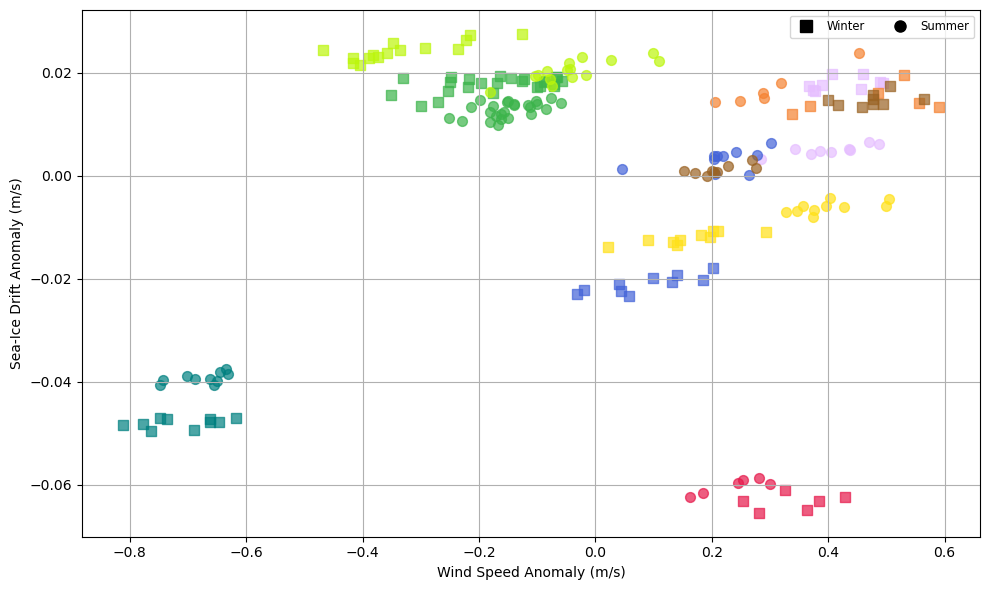

In [61]:
###### 2 points per ensemble 

from matplotlib.lines import Line2D

# --- 1. Discover files ---
wind_folder    = "wind_speed_data/"
sea_ice_folder = "sispeed_data/"

wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))
ice_files  = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

wind_models    = {os.path.basename(f).replace("_wind_speed.csv", ""): f for f in wind_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f for f in ice_files}

common_models = set(wind_models) & set(sea_ice_models)

wind_df_dict = {}
ice_df_dict  = {}
wind_weight  = {}
ice_weight   = {}

for model in common_models:
    wdf = (
        pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
          .resample("M").mean()
    )
    idf = (
        pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
          .resample("M").mean()
    )
    wind_df_dict[model] = wdf
    ice_df_dict[model]  = idf
    wind_weight[model]  = wdf.shape[1]
    ice_weight[model]   = idf.shape[1]

# overlapping monthly index
def get_overlap(d):
    starts = [ts.index.min() for ts in d.values()]
    ends   = [ts.index.max() for ts in d.values()]
    return max(starts), min(ends)

start_w, end_w = get_overlap(wind_df_dict)
start_i, end_i = get_overlap(ice_df_dict)
common_start   = max(start_w, start_i)
common_end     = min(end_w,   end_i)
common_time    = pd.date_range(common_start, common_end, freq="M")

for model in common_models:
    wind_df_dict[model] = wind_df_dict[model].reindex(common_time)
    ice_df_dict[model]  = ice_df_dict[model].reindex(common_time)

total_w_w = sum(wind_weight.values())
total_w_i = sum(ice_weight .values())

wind_all    = pd.Series(index=common_time, dtype=float)
sea_ice_all = pd.Series(index=common_time, dtype=float)

for t in common_time:
    wind_all.loc[t]    = sum(
        wind_weight[m] * wind_df_dict[m].loc[t].mean(skipna=True)
        for m in common_models
    ) / total_w_w
    sea_ice_all.loc[t] = sum(
        ice_weight[m] * ice_df_dict[m].loc[t].mean(skipna=True)
        for m in common_models
    ) / total_w_i

winter_months = {10,11,12,1,2,3}
summer_months = {4,5,6,7,8,9}

plt.figure(figsize=(10, 6))

for model in common_models:
    wdf = wind_df_dict[model]
    idf = ice_df_dict[model]
    color = model_colors.get(model, "#000000")  # define model_colors earlier

    ens_list = wdf.columns.intersection(idf.columns)
    for ens in ens_list:
        # anomalies
        wanom = wdf[ens] - wind_all
        ianom = idf[ens] - sea_ice_all

        # seasonal means
        winter_mask = wanom.index.month.isin(winter_months)
        summer_mask = wanom.index.month.isin(summer_months)

        x_winter = wanom[winter_mask].mean(skipna=True)
        y_winter = ianom[winter_mask].mean(skipna=True)
        x_summer = wanom[summer_mask].mean(skipna=True)
        y_summer = ianom[summer_mask].mean(skipna=True)

        plt.scatter(
            x_winter, y_winter,
            color=color, marker='s', s=50, alpha=0.7
        )
        plt.scatter(
            x_summer, y_summer,
            color=color, marker='o', s=50, alpha=0.7
        )

legend_handles = []

legend_handles.append(Line2D([0], [0], color='k', marker='s', linestyle='',
                             markersize=8, label='Winter'))
legend_handles.append(Line2D([0], [0], color='k', marker='o', linestyle='',
                             markersize=8, label='Summer'))

# for model in common_models:
#     legend_handles.append(Line2D([0], [0], color=model_colors.get(model,"#000000"),
#                                  marker='None', linestyle='-', linewidth=2,
#                                  label=model))

plt.legend(handles=legend_handles, loc='best', fontsize='small', ncol=2)

plt.xlabel("Wind Speed Anomaly (m/s)")
plt.ylabel("Sea‐Ice Drift Anomaly (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()


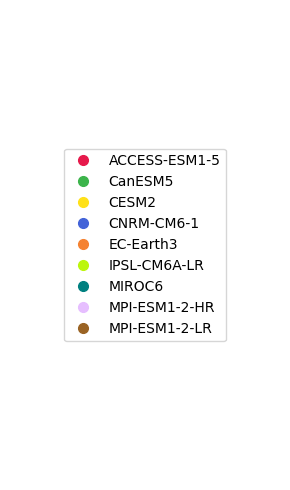

In [28]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

ordered_models = [
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM2",
    "CNRM-CM6-1",
    "EC-Earth3",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
]

model_colors = {     # black
    "ACCESS-ESM1-5": "#e6194b",
    "CanESM5": "#3cb44b",
    "CESM2": "#ffe119",
    "CNRM-CM6-1": "#4363d8",
    "EC-Earth3": "#f58231",
    "GISS-E2-1-G": "#911eb4",
    "GISS-E2-1-H": "#46f0f0",
    "INM-CM5-0": "#f032e6",
    "IPSL-CM6A-LR": "#bcf60c",
    "MIROC-ES2L": "#fabebe",
    "MIROC6": "#008080",
    "MPI-ESM1-2-HR": "#e6beff",
    "MPI-ESM1-2-LR": "#9a6324",
    "MRI-ESM2-0": "#fffac8",
    "NorCPM1": "#800000",
    "UKESM1-0-LL": "#aaffc3"
}

handles = []
for model in ordered_models:
    color = model_colors[model]
    if model == "Observations":
        handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                               markersize=10, label=model)
    else:
        handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                               markersize=7, label=model)
    handles.append(handle)

fig = plt.figure(figsize=(3, 5)) 
ax = fig.add_subplot(111)

legend = ax.legend(handles=handles, loc='center', frameon=True, fontsize=10)

ax.axis('off')

plt.tight_layout()
plt.show()


In [50]:
sample_wind_df = pd.read_csv(wind_files[0], index_col="time", parse_dates=True)
print("Sample wind index:", sample_wind_df.index[:5])

for model in common_models:
    wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    print(f"Model: {model}, Time range: {wind_df.index.min()} - {wind_df.index.max()}")



Sample wind index: DatetimeIndex(['2000-01-16 12:00:00', '2000-02-15 12:00:00',
               '2000-03-16 12:00:00', '2000-04-16 00:00:00',
               '2000-05-16 12:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)
Model: MIROC6, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: ACCESS-ESM1-5, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: IPSL-CM6A-LR, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: CNRM-CM6-1, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: MPI-ESM1-2-HR, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: MPI-ESM1-2-LR, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: CESM2, Time range: 2000-01-15 12:00:00 - 2014-12-15 12:00:00
Model: CanESM5, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00
Model: EC-Earth3, Time range: 2000-01-16 12:00:00 - 2014-12-16 12:00:00


In [63]:
import pandas as pd
import glob
import os

wind_folder = "wind_speed_data/"
sea_ice_folder = "sispeed_data/"

wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))
sea_ice_files = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))

wind_models = {os.path.basename(f).replace("_wind_speed.csv", ""): f for f in wind_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f for f in sea_ice_files}

common_models = set(wind_models.keys()) & set(sea_ice_models.keys())
print("Common Models:", common_models)

results = []
for model in common_models:
    wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    sea_ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    
    common_time = wind_df.index.intersection(sea_ice_df.index)
    if common_time.empty:
        print(f"No common dates for model {model}")
        continue
    wind_df = wind_df.loc[common_time]
    sea_ice_df = sea_ice_df.loc[common_time]
    
    wind_avg = wind_df.mean(axis=1)
    sea_ice_avg = sea_ice_df.mean(axis=1)
    
    corr_value = wind_avg.corr(sea_ice_avg)
    results.append({"Model": model, "Correlation": corr_value})

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by="Correlation", ascending=False)

results_df["Correlation"] = results_df["Correlation"].apply(lambda x: f"{x:.3g}")

styled_df = results_df.style.set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
    ])

from IPython.display import display
display(styled_df)


Common Models: {'ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-HR', 'MIROC6', 'CNRM-CM6-1', 'EC-Earth3', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'CESM2'}


,Model,Correlation
7,MPI-ESM1-2-LR,0.957
1,CanESM5,0.954
3,MIROC6,0.944
2,MPI-ESM1-2-HR,0.917
0,ACCESS-ESM1-5,0.778
5,EC-Earth3,0.765
6,IPSL-CM6A-LR,0.764
8,CESM2,0.715
4,CNRM-CM6-1,-0.0908


Month
1     0.004371
2     0.004461
3     0.004314
4     0.004354
5     0.004449
6     0.004612
7     0.004221
8     0.003527
9     0.003261
10    0.003931
11    0.004353
12    0.004418
dtype: float64


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

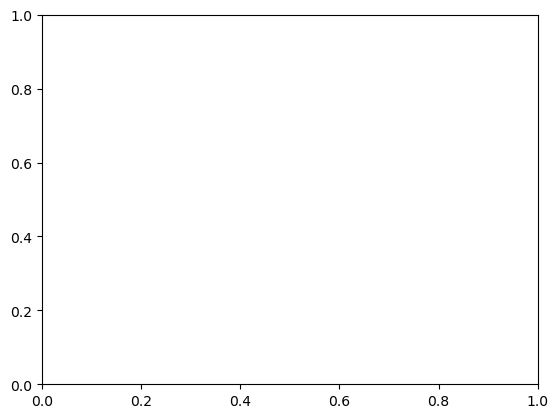

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

months = np.arange(1, 13)

monthly_ratio_df = pd.DataFrame.from_dict(monthly_ratio_dict, orient="columns")
monthly_ratio_df.index.name = "Month"

avg_monthly_ratio = monthly_ratio_df.mean(axis=1)

print(avg_monthly_ratio)
plt.plot(months, avg_monthly_ratio, '--k', linewidth=2, label="Sinusoidal Fit (All Models)")


In [49]:
wind_df = pd.read_csv(wind_models['MIROC6'])
ice_df = pd.read_csv(sea_ice_models['MIROC6'], index_col='time', parse_dates=True)
ice_df.head()

,r10i1p1f1,r1i1p1f1,r2i1p1f1,r3i1p1f1,r4i1p1f1,r5i1p1f1,r6i1p1f1,r7i1p1f1,r8i1p1f1,r9i1p1f1
time,,,,,,,,,,
2000-01-16 12:00:00,0.025059,0.020197,0.018037,0.018096,0.022645,0.023814,0.027842,0.021176,0.019669,0.024880
2000-02-15 12:00:00,0.022045,0.029068,0.018936,0.020936,0.022812,0.022213,0.025564,0.027978,0.023983,0.019419
2000-03-16 12:00:00,0.018521,0.014700,0.023207,0.019829,0.017595,0.021317,0.022283,0.020466,0.020457,0.021717
2000-04-16 00:00:00,0.019287,0.027487,0.026770,0.019116,0.022288,0.026034,0.026657,0.017092,0.014062,0.023472
2000-05-16 12:00:00,0.028249,0.009456,0.019172,0.020686,0.025817,0.025441,0.018236,0.013320,0.018826,0.019951


In [55]:
ice_df

,time,r10i1p1f1,r1i1p1f1,r2i1p1f1,r3i1p1f1,r4i1p1f1,r5i1p1f1,r6i1p1f1,r7i1p1f1,r8i1p1f1,r9i1p1f1
0,2000-01-16 12:00:00,0.046852,0.041969,0.025411,0.026137,0.029127,0.037821,0.033079,0.029088,0.037639,0.033355
1,2000-02-15 12:00:00,0.039864,0.032157,0.026392,0.034547,0.029799,0.034855,0.033667,0.036647,0.036199,0.033015
2,2000-03-16 12:00:00,0.040781,0.024901,0.033872,0.035631,0.042270,0.034784,0.035045,0.020754,0.031899,0.043500
3,2000-04-16 00:00:00,0.044392,0.032224,0.032784,0.039008,0.046176,0.031542,0.026679,0.030399,0.031149,0.031912
4,2000-05-16 12:00:00,0.024649,0.023768,0.022294,0.022878,0.027386,0.032702,0.039523,0.020046,0.033207,0.031785
...,...,...,...,...,...,...,...,...,...,...,...
175,2014-08-16 12:00:00,0.017196,0.018788,0.013461,0.015226,0.013076,0.012490,0.022289,0.018079,0.012803,0.014351
176,2014-09-16 00:00:00,0.020288,0.020990,0.018090,0.020775,0.014562,0.011715,0.020359,0.014811,0.020709,0.021118
177,2014-10-16 12:00:00,0.037627,0.033886,0.028909,0.031870,0.032777,0.024514,0.030425,0.027623,0.031086,0.028436
178,2014-11-16 00:00:00,0.031531,0.048669,0.038233,0.041943,0.025677,0.041772,0.027581,0.026436,0.039885,0.035073


- tandon finding: if you take u and v components to calcualte velocity, becauset heyre fuctaing around zero, mean will tend to be zero. if norm first then monthly averae, itll be muc higher.
- put observations in.
- teslls us drift speed ratio. we can see some of these models have significantly diff drift speeds. 

In [67]:
monthly_ratio_df = pd.DataFrame(monthly_ratio_dict)
monthly_ratio_df.index.name = "Month"
print("\nMonthly Drift Speed Ratio (by model):")
print(monthly_ratio_df)


Monthly Drift Speed Ratio (by model):
       MPI-ESM1-2-LR  GISS-E2-1-G     CESM2    MIROC6  MPI-ESM1-2-HR  \
Month                                                                  
1           0.005761          0.0  0.000404  0.004368       0.006880   
2           0.005944          0.0  0.000439  0.004537       0.007411   
3           0.005840          0.0  0.000422  0.004451       0.007078   
4           0.005752          0.0  0.000387  0.005006       0.006918   
5           0.005384          0.0  0.000361  0.005041       0.006893   
6           0.005024          0.0  0.000387  0.004939       0.006503   
7           0.004143          0.0  0.000338  0.004470       0.005763   
8           0.003212          0.0  0.000336  0.003980       0.004622   
9           0.003280          0.0  0.000342  0.003901       0.004474   
10          0.004709          0.0  0.000401  0.004719       0.006180   
11          0.005731          0.0  0.000413  0.004675       0.006847   
12          0.005810     

In [47]:
import os
print("Current directory:", os.getcwd())

Current directory: /Users/akikomotoki/Documents/Research/sea_ice_variability/Research/sea_ice_velocity_data


/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Pearson Correlation
MPI-ESM1-2-LR,0.738521
GISS-E2-1-G,NaN
CESM2,0.627747
MIROC6,0.552578
MPI-ESM1-2-HR,0.603761
IPSL-CM6A-LR,-0.092366
GISS-E2-1-H,NaN
CNRM-CM6-1,-0.524337
CanESM5,0.763491


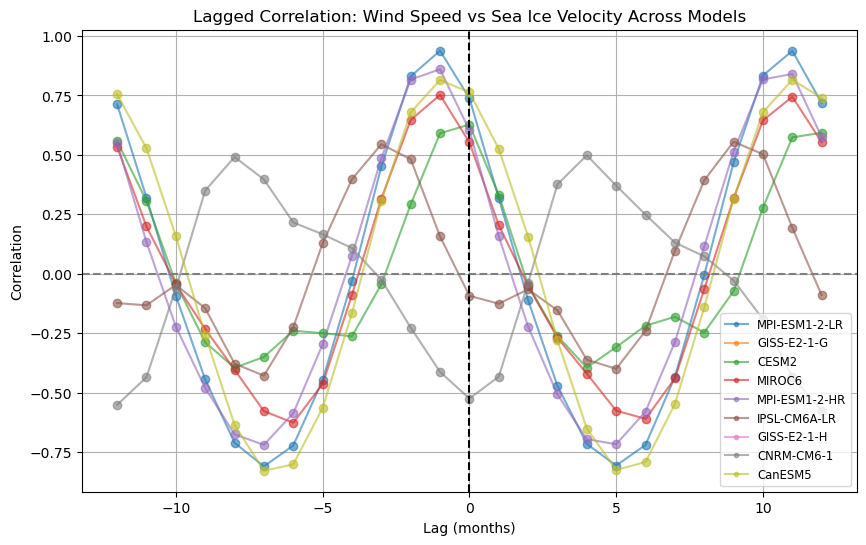

In [41]:
import numpy as np

correlation_results = {}
lagged_correlation_results = {}

max_lag = 12
lags = np.arange(-max_lag, max_lag + 1)

plt.figure(figsize=(10, 6))

for model in common_models:

    wind_df = pd.read_csv(wind_models[model])
    ice_df = pd.read_csv(sea_ice_models[model])

    df = pd.merge(wind_df, ice_df, on="time")

    wind_speed_avg = df.iloc[:, 1:len(wind_df.columns)].mean(axis=1)
    sea_ice_velocity_avg = df.iloc[:, len(wind_df.columns):].mean(axis=1)

    correlation = np.corrcoef(wind_speed_avg, sea_ice_velocity_avg)[0, 1]
    correlation_results[model] = correlation

    lagged_corrs = []
    for lag in lags:
        if lag < 0:
            # wind speed leads (shift ice velocity forward)
            lagged_corr = np.corrcoef(wind_speed_avg[:lag], sea_ice_velocity_avg[-lag:])[0, 1]
        elif lag > 0:
            # ice velocity leads (shift wind speed forward)
            lagged_corr = np.corrcoef(wind_speed_avg[lag:], sea_ice_velocity_avg[:-lag])[0, 1]
        else:
            # no lag (regular correlation)
            lagged_corr = correlation
        lagged_corrs.append(lagged_corr)

    lagged_correlation_results[model] = lagged_corrs

    plt.plot(lags, lagged_corrs, marker="o", label=model, alpha=0.6)

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Lag (months)")
plt.ylabel("Correlation")
plt.title("Lagged Correlation: Wind Speed vs Sea Ice Velocity Across Models")
plt.legend(loc="best", fontsize="small", markerscale=0.5)
plt.grid(True)

correlation_df = pd.DataFrame.from_dict(correlation_results, orient="index", columns=["Pearson Correlation"])

from IPython.display import display
display(correlation_df)


1. Lagged Correlation Plot
- Positive lags (right side of the graph) indicate that sea ice velocity leads wind speed (i.e., sea ice movement happens before wind changes).
- Negative lags (left side of the graph) indicate that wind speed leads sea ice velocity (i.e., wind changes first, then sea ice responds).

- Most models show a strong correlation (~0.75 to 1.0) at certain positive and negative lags, suggesting that wind speed and sea ice velocity are highly related but with a delay.
- The symmetry in peaks (~6-month lag intervals) suggests an influence from seasonal cycles.\
  
2. Pearson Correlation Table
- table presents the direct (zero-lag) Pearson correlation between wind speed and sea ice velocity for each model.
- A high positive correlation (~0.5 to 0.76) for most models (e.g., CanESM5: 0.76, MPI-ESM1-2-LR: 0.74) indicates a strong linear relationship between wind and ice movement.
- Negative correlations (e.g., CNRM-CM6-1: -0.52) suggest opposite behavior, possibly due to regional effects or different ice dynamics in that model.

In [ ]:
drag coefficient